In [1]:
BLACKHOLE = False


import os
import sys
from pathlib import Path
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # fixes problem with graph


if BLACKHOLE:
    workspace_path = os.path.expandvars('$BLACKHOLE')
    sys.path.append(workspace_path+'/DeepLearning/02456_news_project/src')
    DATAPATH = Path(workspace_path+"/DeepLearning/ebnerd_data").expanduser()
else:
    DATAPATH = Path("~/ebnerd_data").expanduser()

#DATASET = "ebnerd_demo"
#DATASET = "ebnerd_small"
DATASET = "ebnerd_large"

In [2]:
import torch

print("torch version:", torch.__version__)

# Check gpu availability


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Test:
#print(torch.zeros(1).cuda())

torch version: 2.5.1+cu124
cuda


In [3]:
from utils.data_handler import NewsDataset
import from_ebrec._constants as cs

SEED = 42
HISTORY_SIZE = 100
CANDITATE_SIZE = 5

COLS = [
    cs.DEFAULT_USER_COL,
    cs.DEFAULT_IMPRESSION_ID_COL,
    cs.DEFAULT_IMPRESSION_TIMESTAMP_COL,
    cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    cs.DEFAULT_CLICKED_ARTICLES_COL,
    cs.DEFAULT_INVIEW_ARTICLES_COL,
]

FRACTION = 0.001
#FRACTION = 0.01
#FRACTION = 0.1
#FRACTION = 1

# test
dataset = NewsDataset()

dataset.setup_df(dataset_path = DATAPATH, datasplit = DATASET, history_size = HISTORY_SIZE, columns = COLS, fraction = FRACTION, seed = SEED, candidate_size=CANDITATE_SIZE)


In [4]:
import transformers as huggingface
from from_ebrec._nlp import get_transformers_word_embeddings
from from_ebrec._polars import concat_str_columns
from from_ebrec._articles import convert_text2encoding_with_transformers
from from_ebrec._articles import create_article_id_to_value_mapping

dataset.setup_articles_data(dataset_path = DATAPATH.joinpath(DATASET))

df_articles = dataset.df_articles

TRANSFORMER_MODEL_NAME = "FacebookAI/xlm-roberta-large"
TEXT_COLUMNS_TO_USE = [cs.DEFAULT_SUBTITLE_COL, cs.DEFAULT_TITLE_COL]
MAX_TITLE_LENGTH = 30

# LOAD HUGGINGFACE:
transformer_model = huggingface.AutoModel.from_pretrained(TRANSFORMER_MODEL_NAME)
transformer_tokenizer = huggingface.AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)

word2vec_embedding = get_transformers_word_embeddings(transformer_model)
df_articles, cat_cal = concat_str_columns(df_articles, columns=TEXT_COLUMNS_TO_USE)
df_articles, token_col_title = convert_text2encoding_with_transformers(df_articles, transformer_tokenizer, cat_cal, max_length=MAX_TITLE_LENGTH)
article_mapping = create_article_id_to_value_mapping(df=df_articles, value_col=token_col_title)



In [5]:
from nrms import NRMSModel
from hyperparameters import hparams_nrms

hparams = hparams_nrms()

BATCH_SIZE = 64

# PARAMETERS
hparams.title_size = MAX_TITLE_LENGTH
hparams.history_size = HISTORY_SIZE
hparams.batch_size = BATCH_SIZE
hparams.candidate_size = CANDITATE_SIZE

# MODEL ARCHITECTURE
hparams.head_num = 32
hparams.head_dim = 32
hparams.attention_hidden_dim = 200
hparams.linear_hidden_dim = 2000
hparams.embedding_dim = word2vec_embedding.shape[1]

hparams.use_positional_encoding = True

hparams.use_time_embedding = False
hparams.time_dim = 1
hparams.time_embedding_dim = 32

# MODEL OPTIMIZER:
hparams.optimizer = "adamw"
hparams.loss = "cross_entropy_loss"
hparams.dropout = 0.3
hparams.learning_rate = 1e-3
hparams.weight_decay = 1e-4
hparams.momentum = 0.9

model = NRMSModel(hparams=hparams, word2vec_embedding=word2vec_embedding)

print(model)


NRMSModel(
  (news_encoder): NewsEncoder(
    (embedding): Embedding(250002, 1024)
    (dropout): Dropout(p=0.3, inplace=False)
    (positional_encoder): PositionEncoder(
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (self_attention): SelfAttention(
      (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
      (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
      (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
    )
    (dense_layers): Sequential(
      (0): Linear(in_features=1024, out_features=2000, bias=True)
      (1): LayerNorm((2000,), eps=1e-05, elementwise_affine=True)
      (2): GELU(approximate='none')
      (3): Dropout(p=0.3, inplace=False)
      (4): Linear(in_features=2000, out_features=2000, bias=True)
      (5): LayerNorm((2000,), eps=1e-05, elementwise_affine=True)
      (6): GELU(approximate='none')
      (7): Dropout(p=0.3, inplace=False)
      (8): Linear(in_features=2000, out_features=1024, bias=

In [6]:
import torch
import torch.nn as nn
print("GPU =",torch.cuda.device_count())
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

GPU = 1


In [7]:
import torch.nn as nn
import torch.optim as optim

# Define the loss function and optimizer
if hparams.loss == "cross_entropy_loss":
    criterion = nn.CrossEntropyLoss()
elif hparams.loss == "mse_loss":
    criterion = nn.MSELoss()
else:
    raise ValueError(f"Loss function {hparams.loss} not supported")

if hparams.optimizer == "adam":
    optimizer = optim.Adam(model.parameters(), lr=hparams_nrms.learning_rate, weight_decay=hparams_nrms.weight_decay)
elif hparams.optimizer == "adamw":
    optimizer = optim.AdamW(model.parameters(), lr=hparams_nrms.learning_rate, weight_decay=hparams_nrms.weight_decay)
elif hparams.optimizer == "sgd":
    optimizer = optim.SGD(model.parameters(), lr=hparams_nrms.learning_rate, momentum=hparams_nrms.momentum)
else:
    raise ValueError(f"Optimizer {hparams.optimizer} not supported")

In [8]:
from dataloader import NRMSDataLoader


train_dataloader = NRMSDataLoader(
    behaviors= dataset.df_train,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column= cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    batch_size=BATCH_SIZE,
)
val_dataloader = NRMSDataLoader(
    behaviors= dataset.df_validation,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column= cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    batch_size=BATCH_SIZE,
)

In [9]:
# dynamic learning rate
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',  # Minimizing validation loss
    factor=0.3,  # Reduce the learning rate by half
    patience=2,  # Wait 2 epochs without improvement
    verbose=True  # Log the learning rate changes
)

c:\Users\andre\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [10]:
# Train the model

EPOCHS = 50

# Move model to GPU if available
model.to(device)

# Training loop
train_loss_history, val_loss_history = [], []

for epoch in range(EPOCHS):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    for iteration, (data, labels) in enumerate(train_dataloader):
        # Unpacking of batch
        his_input_title, pred_input_title, timestamps = data

        # Move data to device
        his_input_title = his_input_title.to(device)
        pred_input_title = pred_input_title.to(device)

        labels = labels.to(device)

        # Forward pass
        outputs = model(pred_input_title, his_input_title)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        print(f"Epoch {epoch + 1}/{EPOCHS}, Train iteration {iteration + 1}/{len(train_dataloader)}: Loss = {loss.item():.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for iteration, (data, labels) in enumerate(val_dataloader):
            his_input_title, pred_input_title, timestamps = data

            his_input_title = his_input_title.to(device)
            pred_input_title = pred_input_title.to(device)
            labels = labels.to(device)

            outputs = model(pred_input_title, his_input_title)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            print(f"Epoch {epoch + 1}/{EPOCHS}, Val iteration {iteration + 1}/{len(val_dataloader)}: Loss = {loss.item():.4f}")

    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    print(f"Epoch {epoch + 1}/{EPOCHS}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    # Update learning rate scheduler
    scheduler.step(val_loss)
    # Log current learning rate
    for param_group in optimizer.param_groups:
        print(f"Current learning rate: {param_group['lr']}")


Epoch 1/50, Train iteration 1/164: Loss = 1.6064
Epoch 1/50, Train iteration 2/164: Loss = 1.6195
Epoch 1/50, Train iteration 3/164: Loss = 1.6324
Epoch 1/50, Train iteration 4/164: Loss = 1.6662
Epoch 1/50, Train iteration 5/164: Loss = 1.6359
Epoch 1/50, Train iteration 6/164: Loss = 1.6246
Epoch 1/50, Train iteration 7/164: Loss = 1.6291
Epoch 1/50, Train iteration 8/164: Loss = 1.6194
Epoch 1/50, Train iteration 9/164: Loss = 1.5887
Epoch 1/50, Train iteration 10/164: Loss = 1.6488
Epoch 1/50, Train iteration 11/164: Loss = 1.7073
Epoch 1/50, Train iteration 12/164: Loss = 1.6609
Epoch 1/50, Train iteration 13/164: Loss = 1.6771
Epoch 1/50, Train iteration 14/164: Loss = 1.6622
Epoch 1/50, Train iteration 15/164: Loss = 1.6224
Epoch 1/50, Train iteration 16/164: Loss = 1.6517
Epoch 1/50, Train iteration 17/164: Loss = 1.6530
Epoch 1/50, Train iteration 18/164: Loss = 1.6948
Epoch 1/50, Train iteration 19/164: Loss = 1.6456
Epoch 1/50, Train iteration 20/164: Loss = 1.6576
Epoch 1/5

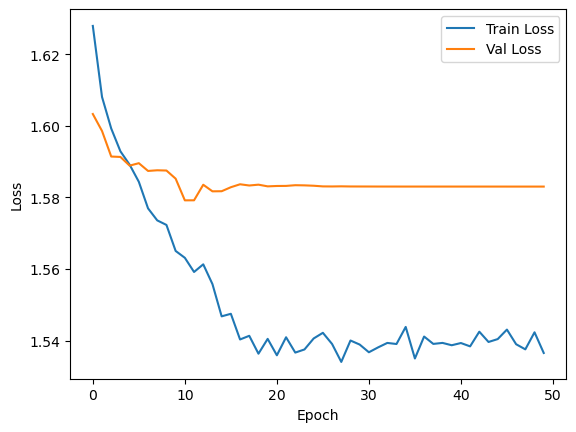

In [11]:
# Plot the loss history
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [12]:
# Evaluate the model
BATCH_SIZE_TEST = 10

dataset.setup_test_data(dataset_path = DATAPATH, datasplit = DATASET, history_size = HISTORY_SIZE, columns = COLS, fraction = FRACTION, seed = SEED, candidate_size=CANDITATE_SIZE)

test_dataloader = NRMSDataLoader(
    behaviors=dataset.df_test,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column=cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    batch_size=BATCH_SIZE_TEST,
)

model.eval()

test_loss = 0.0
pred_test = []
labels_test = []
with torch.no_grad():
    for iteration, (data, labels) in enumerate(test_dataloader):
        his_input_title, pred_input_title, timestamps = data

        his_input_title = his_input_title.to(device)
        pred_input_title = pred_input_title.to(device)
        labels = labels.to(device)

        outputs = model(pred_input_title, his_input_title)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        for i in range(outputs.size(0)):
            pred_test.append(outputs[i].tolist())
            labels_test.append(labels[i].tolist())

        print(f"Test iteration {iteration + 1}/{len(test_dataloader)}: Loss = {loss.item():.4f}")

    test_loss /= len(test_dataloader)
    print("Test loss:", test_loss)

print(pred_test)
print(labels_test)

from from_ebrec.evaluation import MetricEvaluator
from from_ebrec.evaluation import AucScore, MrrScore, NdcgScore
metrics = MetricEvaluator(
    labels = labels_test,
    predictions= pred_test,
    metric_functions=[AucScore(), MrrScore(), NdcgScore(k=5), NdcgScore(k=10)],
)
metrics.evaluate()
print(metrics)



Test iteration 1/1265: Loss = 1.6424
Test iteration 2/1265: Loss = 1.6724
Test iteration 3/1265: Loss = 1.6204
Test iteration 4/1265: Loss = 1.6005
Test iteration 5/1265: Loss = 1.7009
Test iteration 6/1265: Loss = 1.5755
Test iteration 7/1265: Loss = 1.6895
Test iteration 8/1265: Loss = 1.6632
Test iteration 9/1265: Loss = 1.6921
Test iteration 10/1265: Loss = 1.6146
Test iteration 11/1265: Loss = 1.5995
Test iteration 12/1265: Loss = 1.5692
Test iteration 13/1265: Loss = 1.6395
Test iteration 14/1265: Loss = 1.5325
Test iteration 15/1265: Loss = 1.5996
Test iteration 16/1265: Loss = 1.5587
Test iteration 17/1265: Loss = 1.6206
Test iteration 18/1265: Loss = 1.6738
Test iteration 19/1265: Loss = 1.6200
Test iteration 20/1265: Loss = 1.6828
Test iteration 21/1265: Loss = 1.6760
Test iteration 22/1265: Loss = 1.5057
Test iteration 23/1265: Loss = 1.7288
Test iteration 24/1265: Loss = 1.6681
Test iteration 25/1265: Loss = 1.5692
Test iteration 26/1265: Loss = 1.6199
Test iteration 27/126

AUC: 100%|█████████████████████████████| 12649/12649 [00:00<00:00, 37280.80it/s]

<MetricEvaluator class>: 
 {
    "auc": 0.5380860147047197,
    "mrr": 0.5045668959338024,
    "ndcg@5": 0.6256726770845469,
    "ndcg@10": 0.6256726770845469
}


In [13]:
number_to_print = 20
print("Top %d predictions vs labels:" % number_to_print)
labels = dataset.df_test["labels"].to_list()
for i in range(number_to_print):
    print(f"Article {i}")
    for j in range(len(pred_test[i])):
        print(f"{pred_test[i][j]:.3f} vs {labels[i][j]:.3f}")
    print("")





Top 20 predictions vs labels:
Article 0
0.070 vs 0.000
0.011 vs 0.000
0.001 vs 0.000
0.070 vs 0.000
0.848 vs 1.000

Article 1
0.000 vs 0.000
0.015 vs 1.000
0.057 vs 0.000
0.928 vs 0.000
0.000 vs 0.000

Article 2
0.267 vs 0.000
0.106 vs 0.000
0.106 vs 0.000
0.372 vs 0.000
0.150 vs 1.000

Article 3
0.000 vs 1.000
0.274 vs 0.000
0.030 vs 0.000
0.666 vs 0.000
0.030 vs 0.000

Article 4
0.268 vs 0.000
0.032 vs 0.000
0.061 vs 1.000
0.032 vs 0.000
0.607 vs 0.000

Article 5
0.826 vs 0.000
0.029 vs 0.000
0.035 vs 1.000
0.081 vs 0.000
0.029 vs 0.000

Article 6
0.134 vs 0.000
0.134 vs 0.000
0.102 vs 1.000
0.013 vs 0.000
0.618 vs 0.000

Article 7
0.542 vs 1.000
0.212 vs 0.000
0.212 vs 0.000
0.017 vs 0.000
0.016 vs 0.000

Article 8
0.108 vs 0.000
0.130 vs 0.000
0.380 vs 0.000
0.380 vs 0.000
0.001 vs 1.000

Article 9
0.144 vs 0.000
0.442 vs 0.000
0.244 vs 1.000
0.025 vs 0.000
0.144 vs 0.000

Article 10
0.001 vs 0.000
0.023 vs 0.000
0.001 vs 0.000
0.973 vs 1.000
0.003 vs 0.000

Article 11
0.026 vs 0.0

Confusion Matrix:
[[46360  4236]
 [10252  2397]]


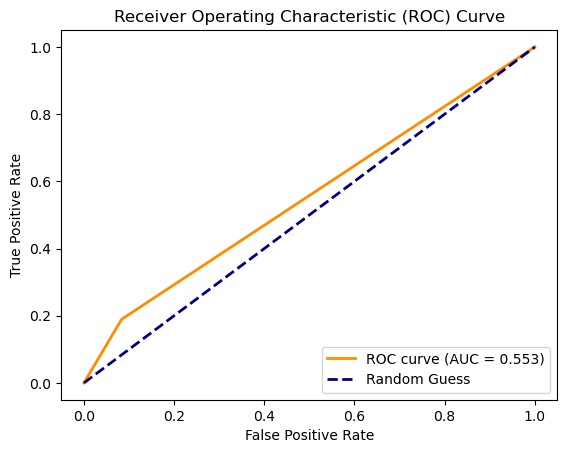

In [14]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt


# Flatten the data for analysis
predicted_probabilities = [prob for article in pred_test for prob in article]
true_values = [val for article in labels[:len(pred_test)] for val in article]


# Set a threshold (commonly 0.5) to classify probabilities as 0 or 1
threshold = 0.5
predicted_classes = [1 if p >= threshold else 0 for p in predicted_probabilities]

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_values, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate AUC and ROC curve
fpr, tpr, thresholds = roc_curve(true_values, predicted_classes)
roc_auc = auc(fpr, tpr)

# Plot ROC curve with AUC value explicitly highlighted
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()